# Transformations
In the final part of this lesson, we will discuss variables transformations. These can be applied either to the outcome variable or to the predictors and can be used for a variety of reasons. Often, transformations are employed so that the model fits better or to correct for violations of certain assumptions. Other times, transformations can be used to help the interpretation of the model, or can be used to add functions of existing predictors to make the fit more flexible. In this part of the lesson, we will discuss methods of transformation for all these purposes.

## Transforming the Outcome
Typically, transformations applied to the outcome variable concern the model fit, but can also be used to improve the assumptions given that any transformation applied to the outcome will be carried into a transformation of the residuals. 

It is important that we constrain the types of transformations we apply to the data. Typically, we only want to consider transformations that are *monotonic*. This means that the order of the data is preserved. One example would be taking $\log y_{i}$, as the data will remain in the same order. However, an example of a *non-monotonic* transformation would be the absolute value $|y_{i}|$ because if there are *negative* values of $y$ they will be made *positive* and the data order will change. A similar situation happens with negative values and $y^{2}$.

### Box-Cox Transformations
Given that there are a wide variety of possible transformations, we could simply guess and try lots of different transformations to see what happens. However, a more principled method was given by [Box & Cox (1964)](http://www.econ.illinois.edu/~econ508/Papers/boxcox64.pdf). Here, transformations of the form $y^{\lambda}_{i}$ are considered. When $\lambda \neq 0$ this is a simple power transformation and when $\lambda = 0$ then this is defined as $\log y_{i}$. This then encompasses a wide-range of possible transformations. For instance, $\lambda = \frac{1}{2}$ would lead to $y^\frac{1}{2}_{i} = \sqrt{y_{i}}$, $\lambda = -1$ would lead to $y^{-1} = \frac{1}{y_{i}}$ and $\lambda = 1$ would lead to $y^{1}_{i} = y_{i}$, indicating that no transformation is needed. 

The utility of this method is that the value of $\lambda$ that makes the data most probable can be found using maximum likelihood. This means that rather than searching through lots of possible transformations, we can just run the Box-Cox method and then evaluate whether a transform seems necessary. Of note, however, is that

- Box-Cox is only defined for $y_{i} > 0$. If your data has negative or 0 values, it will need to first be offset by adding a constant to make all values greater than 0.
- The value of $\lambda$ returned can be anything, which can make the transformed data hard to interpret. If the returned value is close to a more intepretable transformation, you may wish to choose that instead. For instance, if $\hat{\lambda} = 0.46$, you may just wish to use $\hat{\lambda} = 0.5$, which is then equivalent to a square-root transformation.
- Box-Cox is sensitive to outliers, so if you get very large estimated values of $\lambda$ (such as $\hat{\lambda} = 5$), then this is likely the reason. Extreme transformations are almost never warranted.

As an example, we can use the `boxcox()` function from the `MASS` package on our model of `mpg`

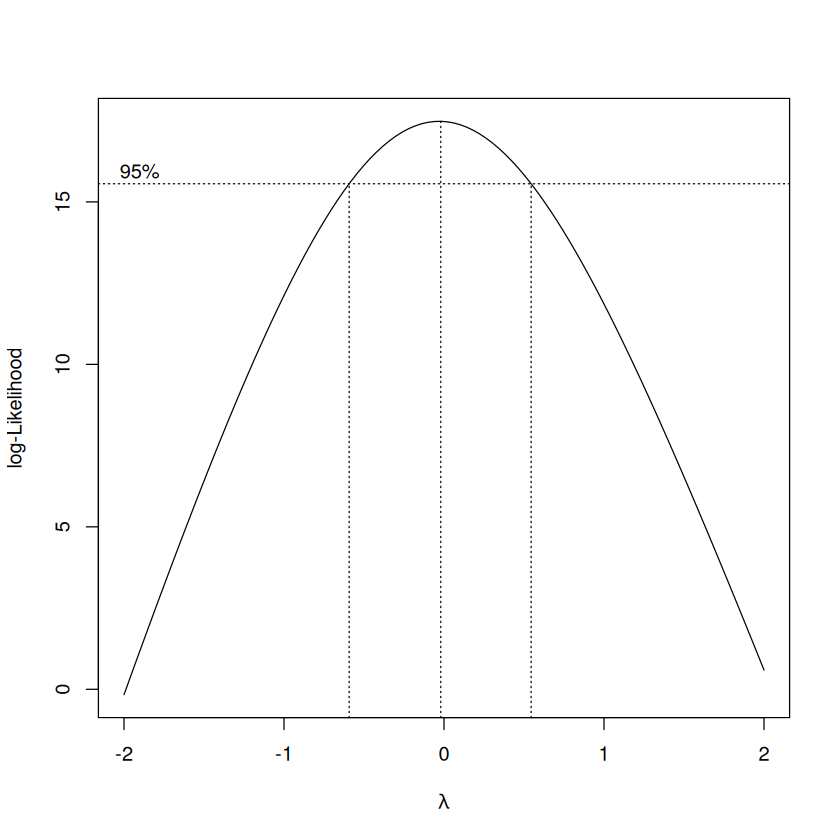

In [83]:
library(MASS)
data(mtcars)
mod <- lm(mpg ~ wt + hp + cyl, data=mtcars)
box <- boxcox(mod)

The plot shows all the values of $\lambda$ that were considered along the $x$-axis and a plot of the log-likelihood along the $y$-axis. We can see that the value that maximises the likelihood is very close to 0, and so we may want to consider a simple log-transformation. If we want to know the precise value of $\hat{\lambda}$ here, we can use

In [84]:
lik      <- box$y
lam      <- box$x 
best.lam <- lam[lik == max(lik)]
print(best.lam)

[1] -0.02020202


We could include this in the regression model by using the formula `I(mpg^best.lam) ~ wt + hp + cy`, however, this is equivalent to the transformation $\frac{1}{\text{MPG}^{0.02}}$, which is not very interpretable. Given that this is very close to $\hat{\lambda} = 0$, we would choose the log-transformation instead. We try this below and create the assumptions plots first for the original mdoel

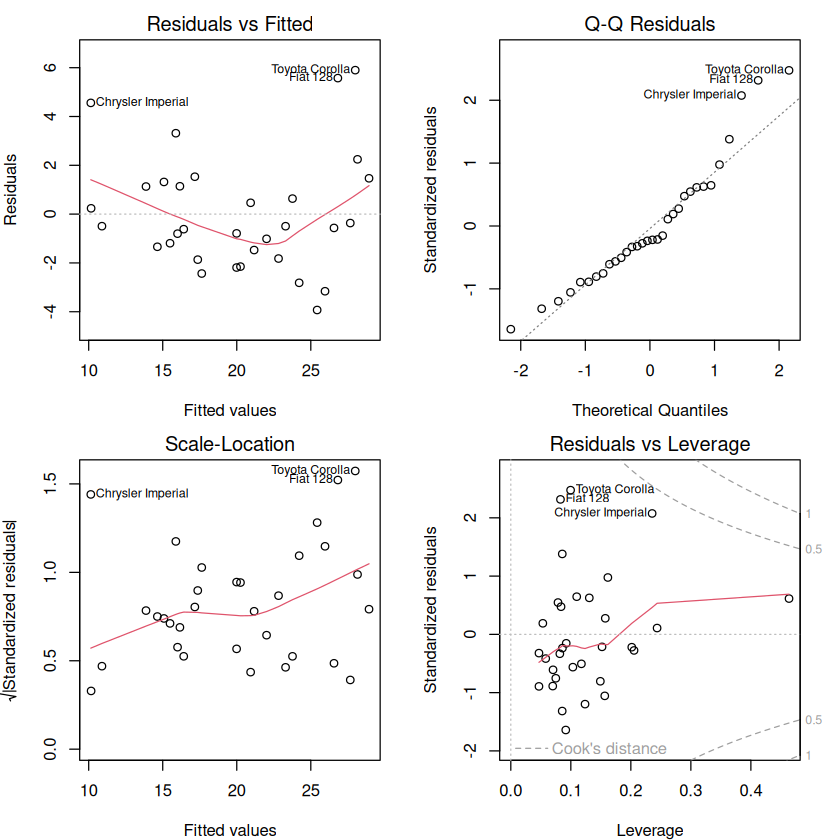

In [85]:
log.mod <- lm(log(mpg) ~ wt + hp + cyl, data=mtcars)
par(mfrow=c(2,2), mar=c(4,4,2,2))
plot(mod)

And then for the log-transformed model

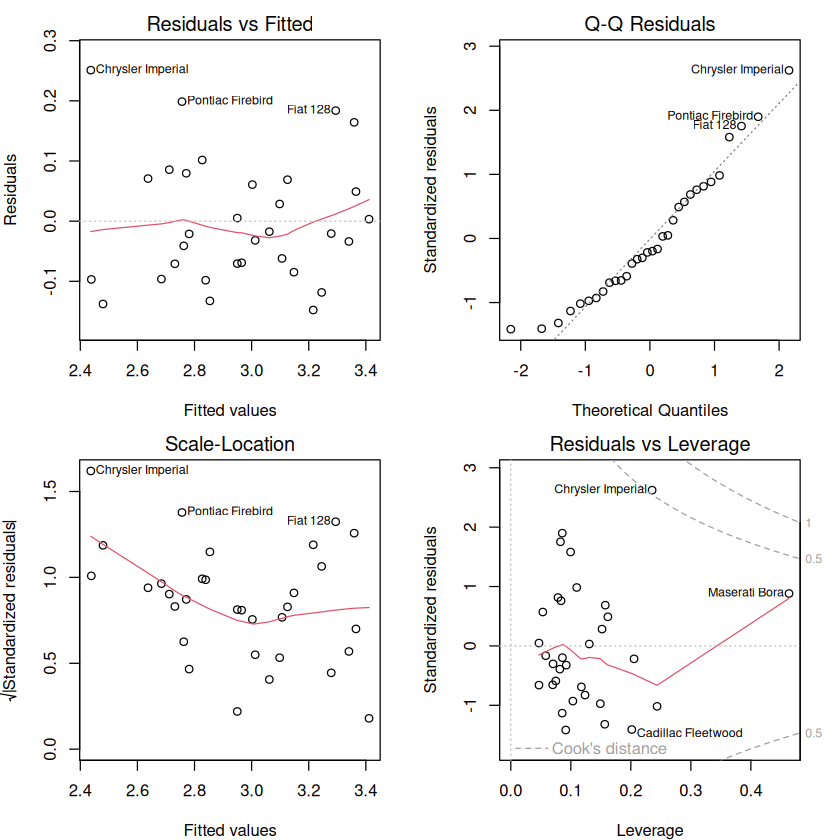

In [86]:
par(mfrow=c(2,2), mar=c(4,4,2,2))
plot(log.mod)

This does seem to have helped, particularly in terms of linearising the relationships in the data and bringing in some of the heavier tails of the residual distribution. We can see this improvement in fit by examining the effects plot for the transformed model.

In [87]:
options(warn=-1)

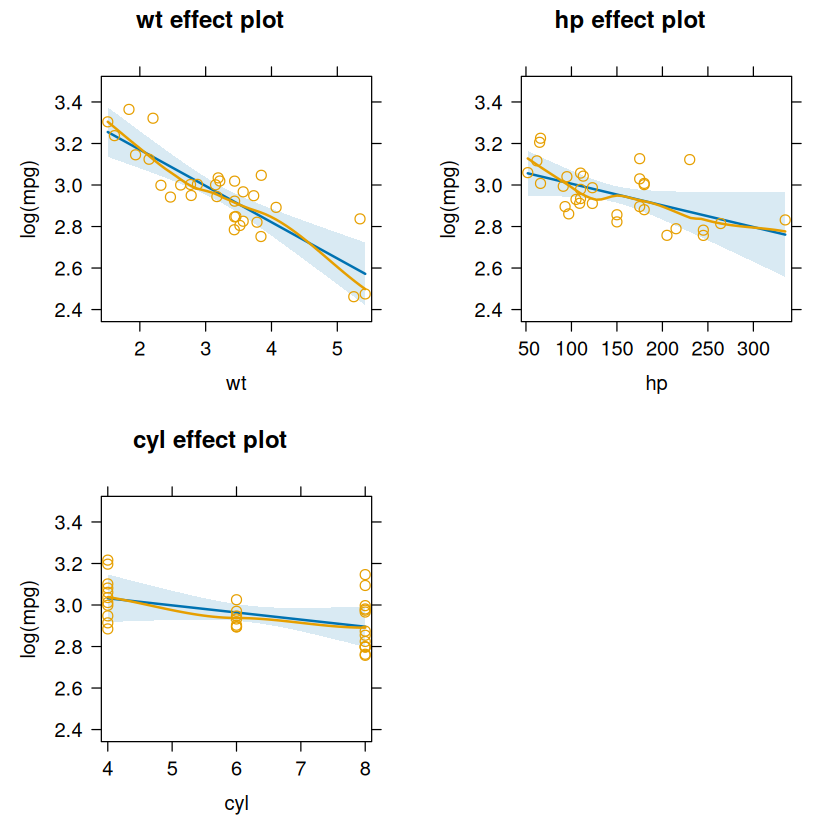

In [88]:
library(effects)
plot(allEffects(log.mod, residuals=TRUE))

Although this seems like a successful application of the Box-Cox method, we always need to take interpretation into account when dealing with transformations. The meaning of the regression coefficients has now changed as they correspond to how much the *log* of the outcome changes for a unit increase in each predictor. This might be quite hard to understand and could be enough to dissuade you from considering any transformations of the outcome, even if the model fit can be improved.

## Transforming the Predictors
As well as the outocme, we can also consider transformations applied to the predictors. Typically, these would be used to either linearise certain relationships in the data, or to model those non-linearities directly. We will see examples of both below.

### Linearising Relationships

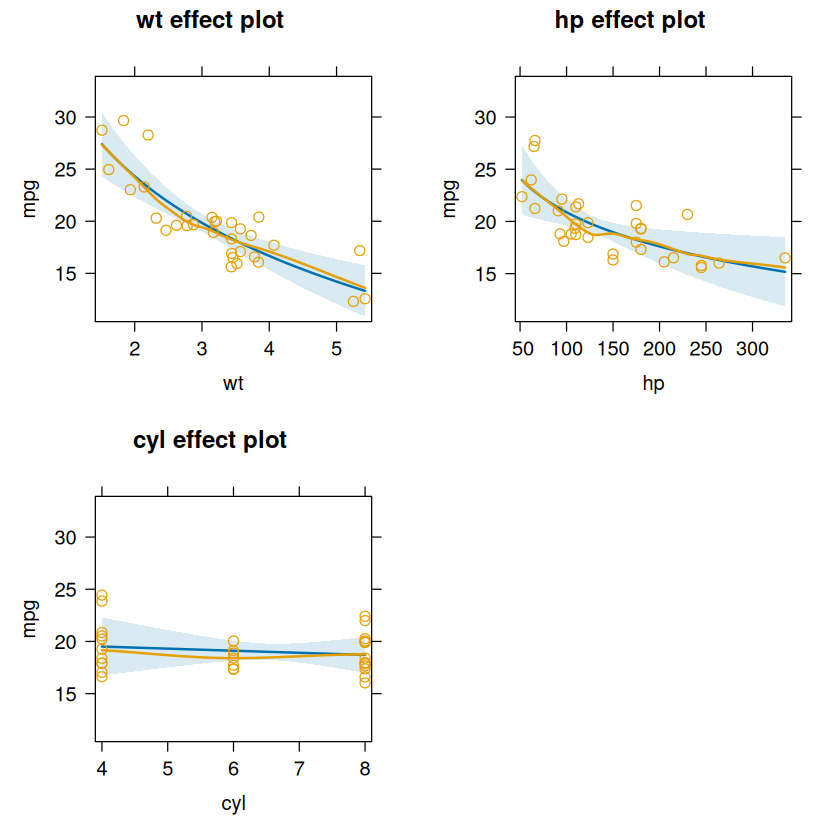

In [89]:
log.pred.mod <- lm(mpg ~ log(wt) + log(hp) + cyl, data=mtcars)
plot(allEffects(log.pred.mod, residuals=TRUE))

So this is *linear* on the log-scale, but *non-linear* on the original scale. We can see this if we fit the same model, but hide the presence of the log-transform by creating some new variables. Because the `effects` package does not know about the log-transform (because it is not inside the model formula), it will not do any rescaling and we can see how the model is really being fit.

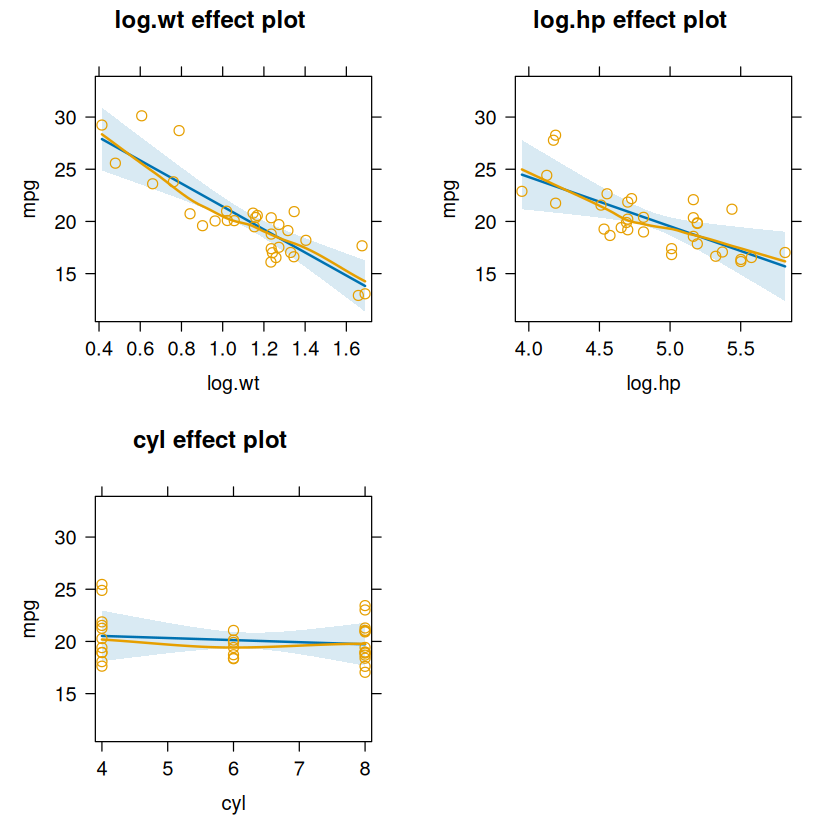

In [90]:
log.wt <- log(mtcars$wt)
log.hp <- log(mtcars$hp)
log.pred.mod <- lm(mpg ~ log.wt + log.hp + cyl, data=mtcars)
plot(allEffects(log.pred.mod, residuals=TRUE))

This makes it clearer that the relationship has been linearised by transforming the predictor onto a new scale.

### Polynomial Regression
A polynomial expansion of a predictor is a form of transformation...


Call:
lm(formula = mpg ~ poly(wt, 2) + poly(hp, 2) + cyl, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7956 -1.8425 -0.3851  1.4348  4.5607 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   19.51609    3.61441   5.400 1.17e-05 ***
poly(wt, 2)1 -18.70421    3.75554  -4.980 3.54e-05 ***
poly(wt, 2)2   6.37935    2.36169   2.701  0.01200 *  
poly(hp, 2)1 -13.63792    4.87670  -2.797  0.00959 ** 
poly(hp, 2)2   5.67410    2.93010   1.936  0.06375 .  
cyl            0.09285    0.58083   0.160  0.87422    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.174 on 26 degrees of freedom
Multiple R-squared:  0.8908,	Adjusted R-squared:  0.8698 
F-statistic: 42.43 on 5 and 26 DF,  p-value: 1.077e-11


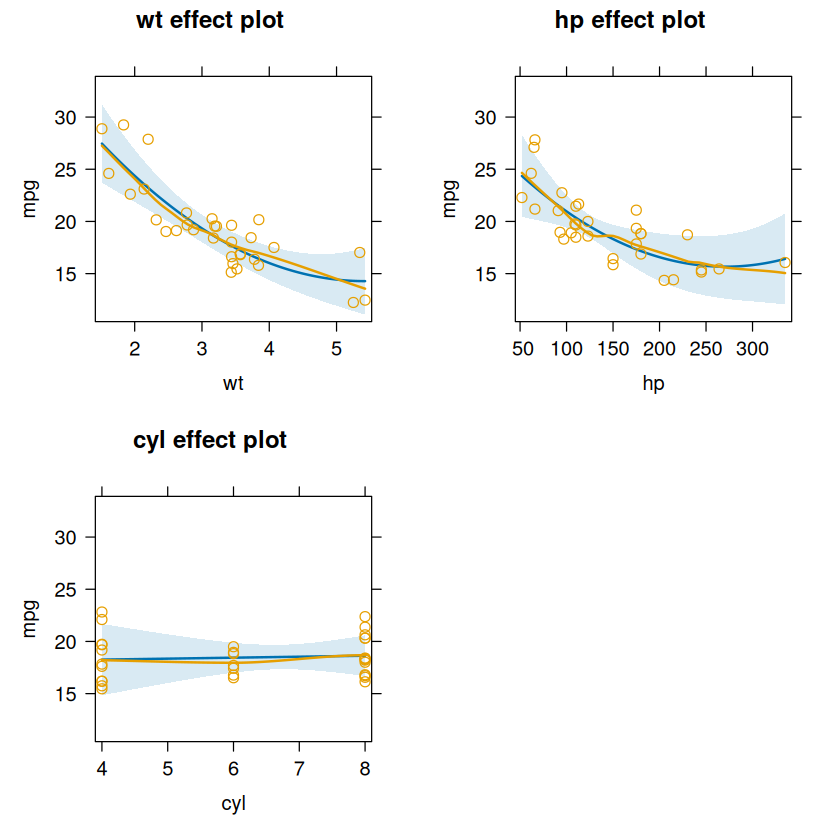

In [91]:
poly.mod <- lm(mpg ~ poly(wt,2) + poly(hp,2) + cyl, data=mtcars)
summary(poly.mod)
plot(allEffects(poly.mod, residuals=TRUE))

This provides a good example of why the `effects` package is so useful, because it is smart enough to know that the polynomial terms should be combined in order to display the fit for both `wt` and `hp`, so we have 3 plots for the 3 variables, rather than 5 plots for the 5 parameters. It is notable that added-variable plots are not this smart, as shown below

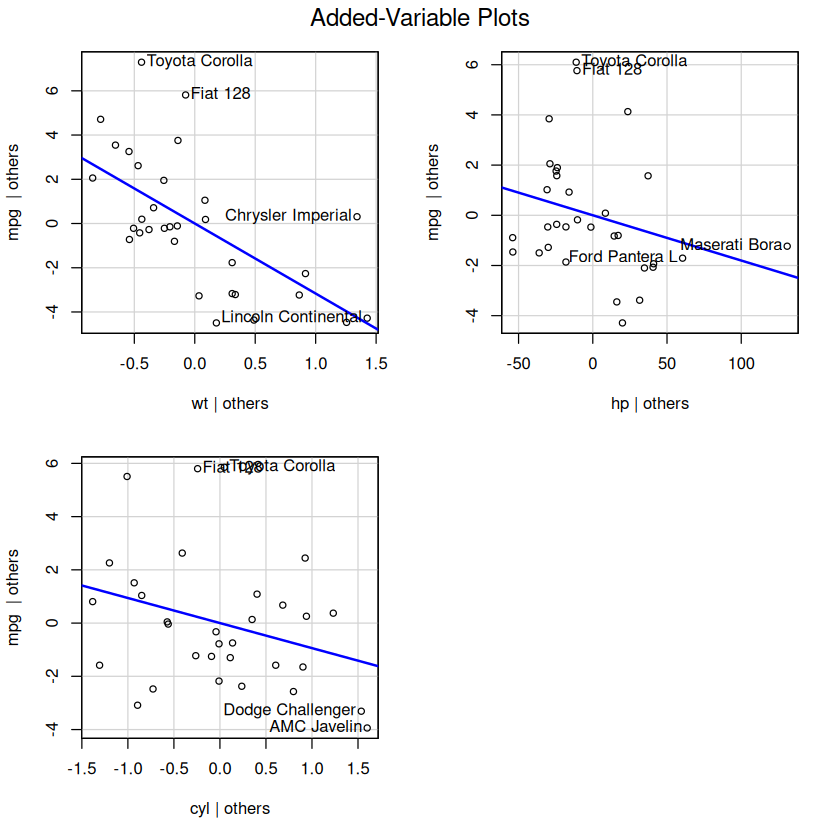

In [92]:
avPlots(mod)

We will see ways of deciding between these model when we discuss model comparison and the ANOVA next week.

## Standardised Regression

## What if Nothing Works?
These include models for outliers (*robust regression*), heteroscedasticity (*generalised least squares*), multicollinearity (*ridge regression*) and non-normality (*non-parametric resampling*).